In [ ]:
import os
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import cv2, numpy as np, xml.etree.ElementTree as ET
import albumentations as A


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Hücre 2
import gdown
import shutil
def download_and_unpack(file_id, dest_folder):
    parent = os.path.dirname(dest_folder)
    os.makedirs(parent, exist_ok=True)
    zip_path = f"{dest_folder}.zip"
    gdown.download(id=file_id, output=zip_path, quiet=False)
    tmp_dir = dest_folder + '_tmp'
    os.makedirs(tmp_dir, exist_ok=True)
    get_ipython().system(f'unzip -q {zip_path} -d {tmp_dir}')

    for root, dirs, files in os.walk(tmp_dir):
        for f in files:
            src = os.path.join(root, f)
            dst = os.path.join(dest_folder, f)
            os.makedirs(dest_folder, exist_ok=True)
            os.replace(src, dst)
    shutil.rmtree(tmp_dir)


train_id = '1lGumpFGdAvLWXhdLJCbkpv-Uo-t8fpHT'
test_id  = '1dJdUIqTfW7InN76Xb3flWVrVmcficP93'


download_and_unpack(train_id, '/content/drone_data/Drone_TrainSet')
download_and_unpack(train_id, '/content/drone_data/Drone_TrainSet_XMLs')
download_and_unpack(test_id,  '/content/drone_data/Drone_TestSet')

print("Veri klasörleri:", os.listdir('/content/drone_data'))


Downloading...
From (original): https://drive.google.com/uc?id=1lGumpFGdAvLWXhdLJCbkpv-Uo-t8fpHT
From (redirected): https://drive.google.com/uc?id=1lGumpFGdAvLWXhdLJCbkpv-Uo-t8fpHT&confirm=t&uuid=1476c78a-e831-4046-8574-b3c009fc5c6e
To: /content/drone_data/Drone_TrainSet.zip
100%|██████████| 4.36G/4.36G [00:41<00:00, 105MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1lGumpFGdAvLWXhdLJCbkpv-Uo-t8fpHT
From (redirected): https://drive.google.com/uc?id=1lGumpFGdAvLWXhdLJCbkpv-Uo-t8fpHT&confirm=t&uuid=f720d130-7375-49fb-ba7d-b786f4f9fcfb
To: /content/drone_data/Drone_TrainSet_XMLs.zip
100%|██████████| 4.36G/4.36G [00:17<00:00, 253MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1dJdUIqTfW7InN76Xb3flWVrVmcficP93
From (redirected): https://drive.google.com/uc?id=1dJdUIqTfW7InN76Xb3flWVrVmcficP93&confirm=t&uuid=1375d04d-d4d1-46bd-b742-46d3e123a167
To: /content/drone_data/Drone_TestSet.zip
100%|██████████| 569M/569M [00:02<00:00, 193MB/s]


Veri klasörleri: ['Drone_TrainSet_XMLs.zip', 'Drone_TrainSet', 'Drone_TestSet', 'Drone_TrainSet_XMLs', 'Drone_TrainSet.zip', 'Drone_TestSet.zip']


In [ ]:
%pip install --upgrade ultralytics segmentation-models-pytorch timm albumentations xmltodict gdown tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [ ]:
# Hücre 3: Dataset ve DataLoader
def xml_to_mask(xml_path, img_h, img_w):
    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    if not os.path.isfile(xml_path):
        return mask
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin, ymin = int(float(bbox.find('xmin').text)), int(float(bbox.find('ymin').text))
        xmax, ymax = int(float(bbox.find('xmax').text)), int(float(bbox.find('ymax').text))
        mask[ymin:ymax, xmin:xmax] = 1
    return mask

class DroneDataset(Dataset):
    def __init__(self, img_dir, xml_dir, transform=None):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.xml_dir = xml_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        xml_path = os.path.join(self.xml_dir, os.path.basename(img_path).replace('.jpg', '.xml'))
        mask = xml_to_mask(xml_path, h, w)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        img = torch.from_numpy(img.transpose(2,0,1)).float()/255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        return img, mask

transform = A.Compose([
    A.Resize(480, 480),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

torch.cuda.empty_cache()
train_ds = DroneDataset(
    img_dir='/content/drone_data/Drone_TrainSet',
    xml_dir='/content/drone_data/Drone_TrainSet_XMLs',
    transform=transform
)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
print(f"Train örnek sayısı: {len(train_ds)}")


Train örnek sayısı: 51446


In [ ]:
# Hücre 4: U‑Net Modeli
import segmentation_models_pytorch as smp
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet_model = smp.Unet(
    encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1
).to(device)

unet_weights = '/content/drive/MyDrive/unet_drone_best.pth'
if os.path.isfile(unet_weights):
    unet_model.load_state_dict(torch.load(unet_weights, map_location=device))
unet_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Hücre 5: YOLOv8 Detection Modeli
from ultralytics import YOLO
yolo_weights = '/content/drive/MyDrive/drone_model/best.pt'
yolo_model = YOLO(yolo_weights)

In [ ]:
# Hücre 7: YOLO Modeli ve Feature Kanal Sayıları
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

yolo_weights = '/content/drive/MyDrive/drone_model/best.pt'
yolo_model = YOLO(yolo_weights).to(device)

# İlk feature bloklarını backbone olarak ayırma
yolo_backbone = nn.Sequential(*list(yolo_model.model.model.children())[:6]).to(device)

# Özellik çıkarım fonksiyonu
def get_feature_channels(model, size=(1,3,480,480)):
    dummy = torch.zeros(size).to(device)
    with torch.no_grad():
        out = model(dummy)
    feat = out[-1] if isinstance(out, (list, tuple)) else out
    return feat.shape[1]

# U‑Net encoder (önceden eğitilmiş ağırlıklar)
import segmentation_models_pytorch as smp
unet_model = smp.Unet(encoder_name='resnet34', encoder_weights=None, in_channels=3, classes=1).to(device)
unet_model.load_state_dict(torch.load('/content/drive/MyDrive/unet_drone_best.pth', map_location=device))

# YOLO ve U‑Net encoder kanal sayıları
cy = get_feature_channels(yolo_backbone)
cu = get_feature_channels(unet_model.encoder)
print(f"YOLO channels: {cy}, U‑Net encoder channels: {cu}")

YOLO channels: 640, U‑Net encoder channels: 512


In [ ]:
# Hücre 8
import timm
import torch.nn as nn
import torch.nn.functional as F

class HybridModelWithViT(nn.Module):
    def __init__(self, yolo_backbone, unet_encoder, cy, cu):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.unet_encoder = unet_encoder
        self.fuse = nn.Conv2d(cy + cu, 512, kernel_size=1)

        # ViT bloğu
        self.vit_block = timm.create_model(
            'vit_tiny_patch16_224',
            pretrained=True,
            in_chans=512,
            num_classes=0
        )

        # Decoder ve Head katmanları
        self.decoder = nn.Conv2d(192, 512, kernel_size=1)
        self.head = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        # Backbone'lardan feature map çıkarımı
        f_y = self.yolo_backbone(x)
        f_u = self.unet_encoder(x)[-1]

        # Spatial boyutları eşitleme
        if f_u.shape[2:] != f_y.shape[2:]:
            f_u = F.interpolate(f_u, size=f_y.shape[2:], mode='bilinear', align_corners=False)

        # Kanal boyutunda birleştirme ve fuse etme
        m = torch.cat([f_y, f_u], dim=1)
        fused_features = self.fuse(m)

        # ViT'ye göndermeden önce öznitelik haritasını 224x224'e büyüt.
        vit_input = F.interpolate(fused_features, size=(224, 224), mode='bilinear', align_corners=False)
        vit_output = self.vit_block.forward_features(vit_input)

        # ViT çıktısını tekrar 2D formata dönüştürme.
        B, _, C = vit_output.shape
        H_vit, W_vit = 14, 14
        vit_features_reshaped = vit_output[:, 1:, :].permute(0, 2, 1).reshape(B, C, H_vit, W_vit)

        # ViT'den gelen öznitelik haritasını, orijinal küçük boyuta geri küçültme.
        original_H, original_W = fused_features.shape[2:]
        vit_features_downscaled = F.interpolate(vit_features_reshaped, size=(original_H, original_W), mode='bilinear', align_corners=False)

        # ViT çıktısını işleyip orijinal öznitelik haritasına ekleme
        decoded_vit_features = self.decoder(vit_features_downscaled)
        final_features = fused_features + decoded_vit_features
        return self.head(final_features)

hybrid_model = HybridModelWithViT(yolo_backbone, unet_model.encoder, cy, cu).to(device)
print(hybrid_model)

--- ValueError Düzeltilmiş Hibrit Model Mimarisi ---
HybridModelWithViT(
  (yolo_backbone): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True,

In [ ]:
# Hücre 9
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset

class DroneSegDataset(Dataset):
    def __init__(self, img_dir, xml_dir, transform=None):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith('.jpg')])
        self.xml_dir = xml_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # XML to mask
        xml_path = os.path.join(self.xml_dir, os.path.basename(img_path).replace('.jpg', '.xml'))
        mask = np.zeros((h, w), dtype=np.uint8)
        if os.path.isfile(xml_path):
            tree = ET.parse(xml_path)
            for obj in tree.findall('object'):
                bbox = obj.find('bndbox')
                xmin = int(float(bbox.find('xmin').text))
                ymin = int(float(bbox.find('ymin').text))
                xmax = int(float(bbox.find('xmax').text))
                ymax = int(float(bbox.find('ymax').text))
                mask[ymin:ymax, xmin:xmax] = 1

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return img, mask

In [ ]:
# Hücre 10
import torch.nn.functional as F
from tqdm.auto import tqdm


import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

train_img_dir = '/content/drone_data/Drone_TrainSet'
train_xml_dir = '/content/drone_data/Drone_TrainSet_XMLs'
batch_size, epochs = 8, 10


transform = A.Compose([
    A.Resize(480, 640),
    A.HorizontalFlip(0.5),
    A.Normalize(),
    ToTensorV2()
])

# Dataset ve DataLoader
train_ds = DroneSegDataset(train_img_dir, train_xml_dir, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

# Optimizör, artık ViT içeren `hybrid_model`'in parametrelerini alacak.
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

loss_history = []
hybrid_model.train()
for e in range(1, epochs+1):
    running = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {e}/{epochs}", leave=False)
    for imgs, masks in loop:
        imgs = imgs.to(device)
        # mask'e bir kanal boyutu ekliyoruz ve float'a çeviriyoruz.
        masks = masks.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        preds = hybrid_model(imgs)

        # Eğer spatial boyutlar eşleşmiyorsa mask'e upsample
        if preds.shape[2:] != masks.shape[2:]:
            preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        running += loss.item()
        loop.set_postfix(loss=running / (loop.n + 1))

    avg = running / len(train_loader)
    loss_history.append(avg)
    print(f"Epoch {e}/{epochs} - Loss: {avg:.4f}")
print("Eğitim tamamlandı!")

Epoch 1/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 0.0182


Epoch 2/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.0157


Epoch 3/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.0138


Epoch 4/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.0131


Epoch 5/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.0121


Epoch 6/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.0116


Epoch 7/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.0109


Epoch 8/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.0106


Epoch 9/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.0105


Epoch 10/10:   0%|          | 0/6431 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.0098
Eğitim tamamlandı!


In [ ]:
full_model_save_path = '/content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth'

# Modeli belirtilen yola kaydet
torch.save(hybrid_model, full_model_save_path)

print(f"Model kaydedildi!")
print(f"Yol: {full_model_save_path}")
print("\n" + "="*50)
print("="*50 + "\n")

Model kaydedildi!
Yol: /content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth




In [ ]:
import gdown
import shutil
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import numpy as np


validation_file_id = '1dJdUIqTfW7InN76Xb3flWVrVmcficP93'
dest_folder = '/content/VALIDATION'
zip_path = f"{dest_folder}.zip"

print("\n[ADIM 1/4] Doğrulama ZIP dosyası indiriliyor...")

if os.path.exists(dest_folder):
    shutil.rmtree(dest_folder)
os.makedirs(dest_folder, exist_ok=True)
gdown.download(id=validation_file_id, output=zip_path, quiet=False)
print(f"'{os.path.basename(dest_folder)}' klasörüne dosyalar açılıyor...")
!unzip -q -o {zip_path} -d {dest_folder}


val_img_dir = os.path.join(dest_folder, 'testset')
val_xml_dir = os.path.join(dest_folder, 'test.xml')

if not os.path.isdir(val_img_dir) or not os.path.isdir(val_xml_dir):
    print("\n!!! HATA !!!")
    print(f"ZIP açıldıktan sonra '{val_img_dir}' veya '{val_xml_dir}' klasörleri bulunamadı.")
    print("Lütfen ZIP dosyasının içeriğini ve klasör isimlerini kontrol edin.")
    print("Mevcut içerik:", os.listdir(dest_folder))
else:
    print("\n[ADIM 2/4] Doğrulama verileri için DataLoader oluşturuluyor...")


    val_transform = A.Compose([
        A.Resize(480, 640),
        A.Normalize(),
        ToTensorV2()
    ])

    validation_dataset = DroneSegDataset(val_img_dir, val_xml_dir, transform=val_transform)
    validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=2)
    print(f"Yeni doğrulama seti oluşturuldu: {len(validation_dataset)} örnek.")

    print("\n[ADIM 3/4] En iyi model yükleniyor ve metrikler hesaplanıyor...")
    best_model_path = '/content/drive/MyDrive/hybrid_model_best.pth' # Eğitimde kaydedilen yol

    if not os.path.exists(best_model_path):
        print(f"Hata: En iyi model bulunamadı: {best_model_path}")
    else:
        # Modeli yükle ve değerlendirme moduna al
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        best_model = torch.load(best_model_path).to(device)
        best_model.eval()

        # Metrikleri hesapla
        total_iou, total_dice, total_pixel_acc, num_batches = 0, 0, 0, len(validation_loader)
        eval_loop = tqdm(validation_loader, desc="Metrikler Hesaplanıyor")

        with torch.no_grad():
            for imgs, masks in eval_loop:
                imgs = imgs.to(device)
                masks = masks.to(device).float().unsqueeze(1)
                preds = torch.sigmoid(best_model(imgs))
                preds_binary = (preds > 0.5).float()

                intersection = torch.sum(preds_binary * masks)
                union = torch.sum(preds_binary) + torch.sum(masks) - intersection
                total_iou += ((intersection + 1e-6) / (union + 1e-6)).item()
                total_dice += ((2. * intersection + 1e-6) / (torch.sum(preds_binary) + torch.sum(masks) + 1e-6)).item()
                total_pixel_acc += (preds_binary == masks).sum().item() / masks.numel()

        print("\n--- SONUÇLAR ---")
        print(f"Ortalama Piksel Doğruluğu: {total_pixel_acc / num_batches:.4f}")
        print(f"Ortalama IoU (Jaccard Index): {total_iou / num_batches:.4f}")
        print(f"Ortalama Dice Katsayısı: {total_dice / num_batches:.4f}")
        print("--------------------------------------\n")

        # Görsel Değerlendirme
        print("[ADIM 4/4] Görsel sonuçlar oluşturuluyor...")

        def denormalize(tensor):
            mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
            img_np = tensor.cpu().numpy().transpose(1, 2, 0)
            return np.clip(std * img_np + mean, 0, 1)

        # Bir batch al ve görselleştir
        images, ground_truths = next(iter(validation_loader))
        images = images.to(device)
        with torch.no_grad():
            predictions = torch.sigmoid(best_model(images)) > 0.5

        plt.figure(figsize=(15, len(images) * 5))
        for i in range(len(images)):
            plt.subplot(len(images), 3, i * 3 + 1)
            plt.imshow(denormalize(images[i]))
            plt.title(f"Giriş Görüntüsü #{i+1}")
            plt.axis('off')

            plt.subplot(len(images), 3, i * 3 + 2)
            plt.imshow(ground_truths[i].squeeze(), cmap='gray')
            plt.title(f"Gerçek Maske #{i+1}")
            plt.axis('off')

            plt.subplot(len(images), 3, i * 3 + 3)
            plt.imshow(predictions[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Tahmin Edilen Maske #{i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()


[ADIM 1/4] Doğrulama ZIP dosyası indiriliyor...


Downloading...
From (original): https://drive.google.com/uc?id=1dJdUIqTfW7InN76Xb3flWVrVmcficP93
From (redirected): https://drive.google.com/uc?id=1dJdUIqTfW7InN76Xb3flWVrVmcficP93&confirm=t&uuid=f91e2d34-79aa-460a-9ce5-648961eb932a
To: /content/VALIDATION.zip
100%|██████████| 569M/569M [00:14<00:00, 40.4MB/s]


'VALIDATION' klasörüne dosyalar açılıyor...

!!! HATA !!!
ZIP açıldıktan sonra '/content/VALIDATION/testset' veya '/content/VALIDATION/test.xml' klasörleri bulunamadı.
Lütfen ZIP dosyasının içeriğini ve klasör isimlerini kontrol edin.
Mevcut içerik: ['Drone_TestSet_XMLs', 'Drone_TestSet']


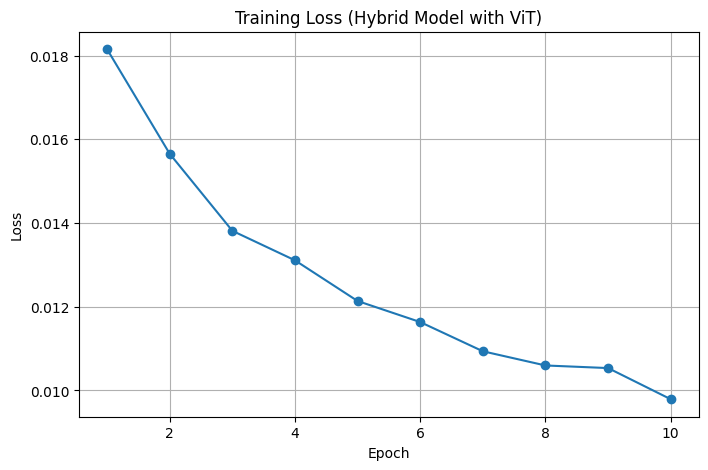

Training Pixel Accuracy (Hybrid with ViT): 0.9945


TypeError: 'NoneType' object is not iterable

In [ ]:
# HÜCRE 12: Eğitim Sonrası Değerlendirme (BU HÜCRE GÜNCELLENDİ)
# ==============================================================================
import matplotlib.pyplot as plt

# Loss grafiği
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('Training Loss (Hybrid Model with ViT)') # <<< ViT ENTEGRASYONU >>> Başlık güncellendi
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Pixel doğruluğu hesabı
# Değerlendirme kodu, herhangi bir ikili segmentasyon modeli için çalıştığından değiştirilmesine gerek yoktur.
hybrid_model.eval()
total_pixels = 0
correct_pixels = 0
with torch.no_grad():
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float().unsqueeze(1)
        preds = hybrid_model(imgs)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()
        if preds.shape[2:] != masks.shape[2:]:
            preds = F.interpolate(preds, size=masks.shape[2:], mode='nearest')
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()
accuracy = correct_pixels / total_pixels
print(f"Training Pixel Accuracy (Hybrid with ViT): {accuracy:.4f}") # <<< ViT ENTEGRASYONU >>> Çıktı metni güncellendi

# Validation döngüsü (Eğer `val_loader` tanımlıysa)
try:
    total_pixels = 0
    correct_pixels = 0
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float().unsqueeze(1)
        preds = hybrid_model(imgs)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()
        if preds.shape[2:] != masks.shape[2:]:
            preds = F.interpolate(preds, size=masks.shape[2:], mode='nearest')
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()
    val_accuracy = correct_pixels / total_pixels
    print(f"Validation Pixel Accuracy (Hybrid with ViT): {val_accuracy:.4f}") # <<< ViT ENTEGRASYONU >>> Çıktı metni güncellendi
except NameError:
    pass

# <<< ViT ENTEGRASYONU >>> Modelin son ağırlıklarını yeni bir isimle kaydediyoruz.
save_path = '/content/drive/MyDrive/hybrid_drone_model_with_vit.pth'
torch.save(hybrid_model.state_dict(), save_path)
print(f'ViT entegreli model ağırlıkları kaydedildi: {save_path}')

In [ ]:
# ==============================================================================
# BÖLÜM 1: YENİ OTURUM İÇİN ORTAM KURULUMU VE GEREKLİ TANIMLAMALAR
# ==============================================================================
print(">>> BÖLÜM 1: Ortam kuruluyor ve gerekli sınıflar tanımlanıyor...")

# Gerekli kütüphaneleri kur/güncelle
%pip install --upgrade ultralytics segmentation-models-pytorch timm albumentations opencv-python matplotlib gdown tqdm -q

# Gerekli tüm kütüphaneleri import et
import os
import shutil
import gdown
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import matplotlib.pyplot as plt
import timm
from ultralytics import YOLO
import segmentation_models_pytorch as smp

# Google Drive'ı bağla
drive.mount('/content/drive')

# --- Veri Seti Sınıfı Tanımı ---
class DroneSegDataset(Dataset):
    def __init__(self, img_dir, xml_dir, transform=None):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith('.jpg')])
        self.xml_dir = xml_dir
        self.transform = transform
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        xml_path = os.path.join(self.xml_dir, os.path.basename(img_path).replace('.jpg', '.xml'))
        if os.path.isfile(xml_path):
            tree = ET.parse(xml_path)
            for obj in tree.findall('object'):
                bbox = obj.find('bndbox')
                xmin, ymin = int(float(bbox.find('xmin').text)), int(float(bbox.find('ymin').text))
                xmax, ymax = int(float(bbox.find('xmax').text)), int(float(bbox.find('ymax').text))
                mask[ymin:ymax, xmin:xmax] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        return img, mask

# --- Model Mimarisi Sınıfı Tanımı ---
class HybridModelWithViT(nn.Module):
    def __init__(self, yolo_backbone, unet_encoder, cy, cu):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.unet_encoder = unet_encoder
        self.fuse = nn.Conv2d(cy + cu, 512, kernel_size=1)
        self.vit_block = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=512, num_classes=0)
        self.decoder = nn.Conv2d(192, 512, kernel_size=1)
        self.head = nn.Conv2d(512, 1, kernel_size=1)
    def forward(self, x):
        f_y = self.yolo_backbone(x)
        f_u = self.unet_encoder(x)[-1]
        if f_u.shape[2:] != f_y.shape[2:]: f_u = F.interpolate(f_u, size=f_y.shape[2:], mode='bilinear', align_corners=False)
        m = torch.cat([f_y, f_u], dim=1)
        fused_features = self.fuse(m)
        vit_input = F.interpolate(fused_features, size=(224, 224), mode='bilinear', align_corners=False)
        vit_output = self.vit_block.forward_features(vit_input)
        B, _, C = vit_output.shape
        H_vit, W_vit = 14, 14
        vit_features_reshaped = vit_output[:, 1:, :].permute(0, 2, 1).reshape(B, C, H_vit, W_vit)
        original_H, original_W = fused_features.shape[2:]
        vit_features_downscaled = F.interpolate(vit_features_reshaped, size=(original_H, original_W), mode='bilinear', align_corners=False)
        decoded_vit_features = self.decoder(vit_features_downscaled)
        final_features = fused_features + decoded_vit_features
        return self.head(final_features)

print(">>> BÖLÜM 1: Kurulum ve tanımlamalar tamamlandı.\n")


print(" BÖLÜM 2: Özel doğrulama süreci ")

# 1. Özel Doğrulama Setini İndir ve Hazırla
validation_file_id = '1dJdUIqTfW7InN76Xb3flWVrVmcficP93'
dest_folder = '/content/VALIDATION'
zip_path = f"{dest_folder}.zip"

if not os.path.exists(dest_folder):
    print("Doğrulama ZIP dosyası indiriliyor...")
    gdown.download(id=validation_file_id, output=zip_path, quiet=False)
    print("Dosyalar açılıyor...")
    !unzip -q -o {zip_path} -d {dest_folder}
else:
    print("Doğrulama seti zaten mevcut.")

val_img_dir = os.path.join(dest_folder, 'Drone_TestSet')
val_xml_dir = os.path.join(dest_folder, 'Drone_TestSet_XMLs')
val_transform = A.Compose([A.Resize(480, 640), A.Normalize(), ToTensorV2()])
validation_dataset = DroneSegDataset(val_img_dir, val_xml_dir, transform=val_transform)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=2)
print(f"Doğrulama seti oluşturuldu: {len(validation_dataset)} örnek.")

# 2. En İyi Modeli Yükle ve Değerlendir
best_model_path = '/content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth'

if not os.path.exists(best_model_path):
    print(f"\n!!! HATA: En iyi model bulunamadı: {best_model_path}")
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"\nModel yükleniyor: {best_model_path}")

    best_model = torch.load(best_model_path, map_location=device, weights_only=False)
    best_model.eval()

    print("Model başarıyla yüklendi.")
    total_iou, total_dice, total_pixel_acc, num_batches = 0, 0, 0, len(validation_loader)

    with torch.no_grad():
        for imgs, masks in tqdm(validation_loader, desc="Metrikler"):
            imgs, masks = imgs.to(device), masks.to(device).float().unsqueeze(1)

            preds = torch.sigmoid(best_model(imgs))

            if preds.shape[-2:] != masks.shape[-2:]:
                preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

            preds_binary = (preds > 0.5).float()

            intersection = torch.sum(preds_binary * masks)
            total_size = torch.sum(preds_binary) + torch.sum(masks)
            epsilon = 1e-6

            total_dice += ((2. * intersection + epsilon) / (total_size + epsilon)).item()
            total_iou += ((intersection + epsilon) / (total_size - intersection + epsilon)).item()
            total_pixel_acc += (preds_binary == masks).sum().item() / masks.numel()

    print("\n--- ÖZEL DOĞRULAMA SETİ SONUÇLARI ---")
    print(f"Ortalama Piksel Doğruluğu: {total_pixel_acc / num_batches:.4f}")
    print(f"Ortalama IoU (Jaccard Index): {total_iou / num_batches:.4f}")
    print(f"Ortalama Dice Katsayısı: {total_dice / num_batches:.4f}")
    print("--------------------------------------\n")


>>> BÖLÜM 1: Ortam kuruluyor ve gerekli sınıflar tanımlanıyor...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> BÖLÜM 1: Kurulum ve tanımlamalar tamamlandı.

 BÖLÜM 2: Özel doğrulama süreci 
Doğrulama seti zaten mevcut.
Doğrulama seti oluşturuldu: 5375 örnek.

Model yükleniyor: /content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth
Model başarıyla yüklendi.


Metrikler:   0%|          | 0/672 [00:00<?, ?it/s]


--- ÖZEL DOĞRULAMA SETİ SONUÇLARI ---
Ortalama Piksel Doğruluğu: 0.9744
Ortalama IoU (Jaccard Index): 0.3711
Ortalama Dice Katsayısı: 0.4301
--------------------------------------



In [ ]:
#Validation Görselleri Üzerinde Maskeleme

import os
import shutil
import gdown
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import matplotlib.pyplot as plt
import timm

# Google Drive'ı bağla
drive.mount('/content/drive')

# Veri Seti Sınıfı Tanımı
class DroneSegDataset(Dataset):
    def __init__(self, img_dir, xml_dir, transform=None):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith('.jpg')])
        self.xml_dir = xml_dir
        self.transform = transform
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        xml_path = os.path.join(self.xml_dir, os.path.basename(img_path).replace('.jpg', '.xml'))
        if os.path.isfile(xml_path):
            tree = ET.parse(xml_path)
            for obj in tree.findall('object'):
                bbox = obj.find('bndbox')
                xmin, ymin = int(float(bbox.find('xmin').text)), int(float(bbox.find('ymin').text))
                xmax, ymax = int(float(bbox.find('xmax').text)), int(float(bbox.find('ymax').text))
                mask[ymin:ymax, xmin:xmax] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        return img, mask

# Model Mimarisi Sınıfı Tanımı
class HybridModelWithViT(nn.Module):
    def __init__(self, yolo_backbone, unet_encoder, cy, cu):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.unet_encoder = unet_encoder
        self.fuse = nn.Conv2d(cy + cu, 512, kernel_size=1)
        self.vit_block = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=512, num_classes=0)
        self.decoder = nn.Conv2d(192, 512, kernel_size=1)
        self.head = nn.Conv2d(512, 1, kernel_size=1)
    def forward(self, x):
        f_y = self.yolo_backbone(x)
        f_u = self.unet_encoder(x)[-1]
        if f_u.shape[2:] != f_y.shape[2:]: f_u = F.interpolate(f_u, size=f_y.shape[2:], mode='bilinear', align_corners=False)
        m = torch.cat([f_y, f_u], dim=1)
        fused_features = self.fuse(m)
        vit_input = F.interpolate(fused_features, size=(224, 224), mode='bilinear', align_corners=False)
        vit_output = self.vit_block.forward_features(vit_input)
        B, _, C = vit_output.shape
        H_vit, W_vit = 14, 14
        vit_features_reshaped = vit_output[:, 1:, :].permute(0, 2, 1).reshape(B, C, H_vit, W_vit)
        original_H, original_W = fused_features.shape[2:]
        vit_features_downscaled = F.interpolate(vit_features_reshaped, size=(original_H, original_W), mode='bilinear', align_corners=False)
        decoded_vit_features = self.decoder(vit_features_downscaled)
        final_features = fused_features + decoded_vit_features
        return self.head(final_features)


print("Rastgele görsel değerlendirme süreci")

# Doğrulama Seti
validation_file_id = '1dJdUIqTfW7InN76Xb3flWVrVmcficP93'
dest_folder = '/content/VALIDATION'
zip_path = f"{dest_folder}.zip"

if not os.path.exists(dest_folder):
    print("Doğrulama ZIP dosyası indiriliyor...")
    gdown.download(id=validation_file_id, output=zip_path, quiet=False)
    print("Dosyalar açılıyor...")
    !unzip -q -o {zip_path} -d {dest_folder}
else:
    print("Doğrulama seti zaten mevcut.")

val_img_dir = os.path.join(dest_folder, 'Drone_TestSet')
val_xml_dir = os.path.join(dest_folder, 'Drone_TestSet_XMLs')
val_transform = A.Compose([A.Resize(480, 640), A.Normalize(), ToTensorV2()])
validation_dataset = DroneSegDataset(val_img_dir, val_xml_dir, transform=val_transform)

# Batch size, tek seferde 15 rastgele örnek
validation_loader = DataLoader(validation_dataset, batch_size=15, shuffle=True, num_workers=2)
print(f"Rastgele örnekler için doğrulama seti oluşturuldu: {len(validation_dataset)} örnek.")

best_model_path = '/content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth'

if not os.path.exists(best_model_path):
    print(f"\n!!! HATA: En iyi model bulunamadı: {best_model_path}")
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"\nModel yükleniyor: {best_model_path}")

    best_model = torch.load(best_model_path, map_location=device, weights_only=False)
    best_model.eval()

    print("Model başarıyla yüklendi. Rastgele 15 örnek üzerinde tahmin yapılıyor...")


    def denormalize(tensor):
        mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
        img_np = tensor.cpu().numpy().transpose(1, 2, 0)
        return np.clip(std * img_np + mean, 0, 1)

    # DataLoader'dan sadece bir batch (15 rastgele örnek) al
    images, ground_truths = next(iter(validation_loader))

    with torch.no_grad():
        predictions_small = torch.sigmoid(best_model(images.to(device)))
        predictions = F.interpolate(predictions_small, size=ground_truths.shape[1:], mode='bilinear', align_corners=False)
        predictions_binary = predictions > 0.5


    num_samples = len(images)
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(denormalize(images[i]))
        plt.title(f"Giriş #{i+1}")
        plt.axis('off')

        # Gerçek Maske
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(ground_truths[i].squeeze(), cmap='gray')
        plt.title(f"Gerçek Maske #{i+1}")
        plt.axis('off')

        # Tahmin (Bindirilmiş)
        plt.subplot(num_samples, 3, i * 3 + 3)
        original_image_np = (denormalize(images[i]) * 255).astype(np.uint8)
        predicted_mask_np = predictions_binary[i].squeeze().cpu().numpy().astype(np.uint8)

        overlay = original_image_np.copy()
        overlay[predicted_mask_np == 1] = [0, 255, 0] # Yeşil renk

        blended_image = cv2.addWeighted(original_image_np, 0.6, overlay, 0.4, 0)

        plt.imshow(blended_image)
        plt.title(f"Tahmin #{i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Video üzerinde model kullanım hücresi
print(">>> BÖLÜM 1: Ortam kuruluyor ve gerekli sınıflar tanımlanıyor...")


%pip install --upgrade ultralytics segmentation-models-pytorch timm albumentations opencv-python matplotlib gdown tqdm -q
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import matplotlib.pyplot as plt
import timm
from ultralytics import YOLO
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm

drive.mount('/content/drive')

# Sınıf Tanımları
class HybridModelWithViT(nn.Module):
    def __init__(self, yolo_backbone, unet_encoder, cy, cu):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.unet_encoder = unet_encoder
        self.fuse = nn.Conv2d(cy + cu, 512, kernel_size=1)
        self.vit_block = timm.create_model('vit_tiny_patch16_224', pretrained=True, in_chans=512, num_classes=0)
        self.decoder = nn.Conv2d(192, 512, kernel_size=1)
        self.head = nn.Conv2d(512, 1, kernel_size=1)
    def forward(self, x):
        f_y = self.yolo_backbone(x)
        f_u = self.unet_encoder(x)[-1]
        if f_u.shape[2:] != f_y.shape[2:]: f_u = F.interpolate(f_u, size=f_y.shape[2:], mode='bilinear', align_corners=False)
        m = torch.cat([f_y, f_u], dim=1)
        fused_features = self.fuse(m)
        vit_input = F.interpolate(fused_features, size=(224, 224), mode='bilinear', align_corners=False)
        vit_output = self.vit_block.forward_features(vit_input)
        B, _, C = vit_output.shape
        H_vit, W_vit = 14, 14
        vit_features_reshaped = vit_output[:, 1:, :].permute(0, 2, 1).reshape(B, C, H_vit, W_vit)
        original_H, original_W = fused_features.shape[2:]
        vit_features_downscaled = F.interpolate(vit_features_reshaped, size=(original_H, original_W), mode='bilinear', align_corners=False)
        decoded_vit_features = self.decoder(vit_features_downscaled)
        final_features = fused_features + decoded_vit_features
        return self.head(final_features)

print("BÖLÜM 1: Kurulum ve tanımlamalar tamamlandı.\n")


# VİDEO İŞLEME SÜRECİ

print(">>> BÖLÜM 2: Video işleme süreci başlatılıyor...")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = '/content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth' # modelin yolu

if not os.path.exists(model_path):
    print(f"\n!!! HATA: Model dosyası bulunamadı: {model_path}")
else:
    print(f"Model yükleniyor: {model_path}")
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()
    print("Model yüklendi ve değerlendirme moduna alındı.")

    # Video Yolları
    input_video_path = '/content/drive/MyDrive/DRONEMURAT.mp4'
    output_video_path = '/content/drive/MyDrive/DRONEMURAT_MASKED.mp4'

    # doğrulama seti ile aynı dönüşümler
    transform = A.Compose([
        A.Resize(480, 640),
        A.Normalize(),
        ToTensorV2()
    ])

#Video Okuma ve Yazma Döngüsü
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Hata: Video açılamadı -> {input_video_path}")
    else:
        # Video özellikleri
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Çıktı videosu için yazıcı
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        print(f"\nVideo işleniyor... Toplam {total_frames} kare.")

        # Her kareyi işlemek için döngü
        for _ in tqdm(range(total_frames), desc="Video Kareleri İşleniyor"):
            ret, frame = cap.read()
            if not ret:
                break

            # A. Kareyi Hazırla
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            augmented = transform(image=img_rgb)
            img_tensor = augmented['image'].unsqueeze(0).to(device)

            # B. Tahmin Yap
            with torch.no_grad():
                pred_small = torch.sigmoid(model(img_tensor))
                # Tahmini orijinal kare boyutuna büyüt
                pred_large = F.interpolate(pred_small, size=(height, width), mode='bilinear', align_corners=False)
                # Eşikleme ile ikili maske oluştur
                mask_binary = (pred_large > 0.5).squeeze().cpu().numpy().astype(np.uint8)

            # C. Sonucu Görselleştir (Overlay)
            # Yeşil renkte bir maske katmanı
            green_mask_overlay = np.zeros_like(frame, dtype=np.uint8)
            green_mask_overlay[mask_binary == 1] = [0, 255, 0] # Yeşil

            # Orijinal kare ile maskeyi birleştir
            blended_frame = cv2.addWeighted(frame, 0.7, green_mask_overlay, 0.3, 0)

            # D. İşlenmiş Kareyi Çıktı Videosuna Yaz
            out.write(blended_frame)

        cap.release()
        out.release()
        print("\nİşlem tamamlandı!")
        print(f"Maskelenmiş video kaydedildi: {output_video_path}")

>>> BÖLÜM 1: Ortam kuruluyor ve gerekli sınıflar tanımlanıyor...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> BÖLÜM 1: Kurulum ve tanımlamalar tamamlandı.

>>> BÖLÜM 2: Video işleme süreci başlatılıyor...
Model yükleniyor: /content/drive/MyDrive/hybrid_drone_model_with_vit_FULL.pth
Model yüklendi ve değerlendirme moduna alındı.

Video işleniyor... Toplam 9246 kare.


Video Kareleri İşleniyor:   0%|          | 0/9246 [00:00<?, ?it/s]


İşlem tamamlandı!
Maskelenmiş video kaydedildi: /content/drive/MyDrive/DRONEMURAT_MASKED.mp4
